In [5]:
from datetime import datetime

In [85]:
import sunpy.map

In [111]:
calib_ratio = eis_ea(float(test_eis.meta['line_id'].split(' ')[-1]))/eis_ea_nrl(test_eis.date.value, float(test_eis.meta['line_id'].split(' ')[-1]))

[0.16098046]


In [7]:
def get_time_tai(date_string):
    # get the current time in TAI - specific for IDL.

    # IDL reference epoch: January 1, 1979, 00:00:00
    idl_ref_epoch = datetime(1979, 1, 1)

    # Unix epoch: January 1, 1970, 00:00:00
    unix_epoch = datetime(1970, 1, 1)

    # Calculate the difference in seconds between the IDL reference epoch and the Unix epoch
    epoch_diff = (idl_ref_epoch - unix_epoch).total_seconds()

    date_object = datetime.fromisoformat(date_string)
    unix_timestamp = date_object.timestamp()

    # Adjust the Unix timestamp by subtracting the epoch difference
    idl_timestamp = unix_timestamp - epoch_diff+3600

    return idl_timestamp

In [8]:
def read_calib_file():
    from scipy.io import readsav

    # Read the calibration file
    calib_file = readsav('eis_calibration/eis_calib_warren_2014.sav')
    return calib_file['eis']


In [41]:
eis = read_calib_file()

In [11]:
date = '2023-12-28T23:59:59'
get_time_tai(date)

1419814799.0

In [42]:
date = '2023-12-28T23:59:59'%%javascript
t = (get_time_tai(date) - get_time_tai(eis['t0'][0].decode('utf-8')))/(86400.*365.25)
# tested, same in IDL

In [43]:
def eis_get_band(wave):
    # get band based on the wavelength
    band = ''
    sw_min = 165
    sw_max = 213
    pShort = (wave - sw_min) * (sw_max - wave)
    if pShort >= 0:
        band = 'SW'

    lw_min = 245
    lw_max = 292
    pLong = (wave - lw_min) * (lw_max - wave)
    if pLong >= 0:
        band = 'LW'

    return band

In [44]:
get_time_tai(date)

1419811199.0

In [55]:
t = (get_time_tai(date) - get_time_tai(eis['t0'][0].decode('utf-8')))/(86400*365.25)


In [56]:
ea_knots_SW = eis['a0_sw'][0]*np.exp(-t/eis['tau_sw'][0])
ea_knots_LW = eis['a0_lw'][0]*np.exp(-t/eis['tau_lw'][0])


In [58]:
eis['wave_area_sw'][0]

array([165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 188., 189., 190., 191., 192., 193., 194., 195., 196., 197.,
       198., 199., 200., 201., 202., 203., 204., 205., 206., 207., 208.,
       209., 210., 211., 212., 213.], dtype='>f4')

In [73]:
import numpy as np
from scipy.interpolate import splrep, splev

def eis_ea_nrl(date, wave, short=False, long=False):
    eis = read_calib_file()
    t = (get_time_tai(date) - get_time_tai(eis['t0'][0].decode('utf-8')))/(86400*365.25)

    ea_knots_SW = eis['a0_sw'][0]*np.exp(-t/eis['tau_sw'][0])
    ea_knots_LW = eis['a0_lw'][0]*np.exp(-t/eis['tau_lw'][0])

    # -----------------------------------------------------------------
    # --- return the effective area on a default wavelength grid
    if short:
        wave = eis['wave_area_sw'][0]
    elif long:
        wave = eis['wave_area_lw'][0]

    # -----------------------------------------------------------------
    # --- spline onto the input wavelength grid
    if isinstance(wave, (int, float)):
        wave = np.array([wave])

    nWave = len(wave)
    ea_out = np.zeros(nWave)

    for i in range(nWave):
        band = eis_get_band(wave[i])

        if band == 'SW':
            w = eis['wave_knots_sw'][0]
            e = np.log(ea_knots_SW)
            s = 1
        elif band == 'LW':
            w = eis['wave_knots_lw'][0]
            e = np.log(ea_knots_LW)
            s = 1
        else:
            print(f"WAVELENGTH OUT OF BOUNDS {wave[i]}")
            s = 0

        if s == 1:
            tck = splrep(w, e)
            ea_out[i] = np.exp(splev(wave[i], tck))
            
        else:
            ea_out[i] = 0.0

    if nWave == 1:
        ea_out = ea_out[0]

    return ea_out


In [79]:
import numpy as np
from scipy.io import readsav
def eis_ea(input_wave, short=False, long=False):
    if short:
        wave, ea = eis_effective_area_read(short=True)
        input_wave = wave
        print(input_wave)
        return ea

    if long:
        wave, ea = eis_effective_area_read(long=True)
        input_wave = wave
        return ea
    if isinstance(input_wave, (int, float)):
        input_wave = np.array([input_wave])

    nWave = len(input_wave)
    ea = np.zeros(nWave)

    for i in range(nWave):
        short, long = is_eis_wavelength(input_wave[i])

        if not short and not long:
            ea[i] = 0.0
        else:
            wave, area = eis_effective_area_read(long=long, short=short)
            ea[i] = np.exp(np.interp(input_wave[i], wave, np.log(area)))

    if nWave == 1:
        ea = ea[0]

    return ea

def eis_effective_area_read(short=False, long=False):
    if short:
        preflight = readsav('eis_calibration/preflight_calib_short.sav')
    if long:
        preflight = readsav('eis_calibration/preflight_calib_long.sav')
    wave = preflight['wave']
    ea = preflight['ea']
    return wave, ea

def is_eis_wavelength(input_wave):
    wave_sw_min = 165
    wave_sw_max = 213
    wave_lw_min = 245
    wave_lw_max = 292

    long = False
    short = False

    ps = (input_wave - wave_sw_min) * (wave_sw_max - input_wave)
    if ps > 0:
        short = True

    pl = (input_wave - wave_lw_min) * (wave_lw_max - input_wave)
    if pl > 0:
        long = True

    out = long or short
    return short,long


In [83]:
eis_ea(195)

0.30180300929913173

In [84]:
date = '2007-12-28T23:59:59'

eis_ea_nrl(date,195)

[0.41812794]


0.4181279443915417

In [87]:
type(195.12) == float

True

In [95]:
input_wave = 195.12

In [96]:
input_wave = [input_wave]

In [97]:
input_wave

[195.12]

In [104]:
len(np.array([[195.12,193]]))

1

In [128]:
import matplotlib.pyplot as plt
import numpy as np

In [133]:
comp = np.load('/Users/andysh.to/Downloads/eis_20230327_092942_composition_sis.npz')

In [166]:
comp

NpzFile '/Users/andysh.to/Downloads/eis_20230327_092942_composition_sis.npz' with keys: composition, chi2, no_lines

In [167]:
comp['no_lines']

array([[ 9.,  9.,  9., ...,  6.,  6.,  5.],
       [12., 12., 12., ...,  7.,  6.,  8.],
       [12., 12., 12., ...,  7.,  7.,  8.],
       ...,
       [11., 16., 17., ..., 15., 13., 14.],
       [11., 16., 17., ..., 15., 16., 14.],
       [ 3.,  7.,  8., ...,  6.,  5.,  5.]])

Text(0.5, 1.0, 'EISPAC Default Calibration')

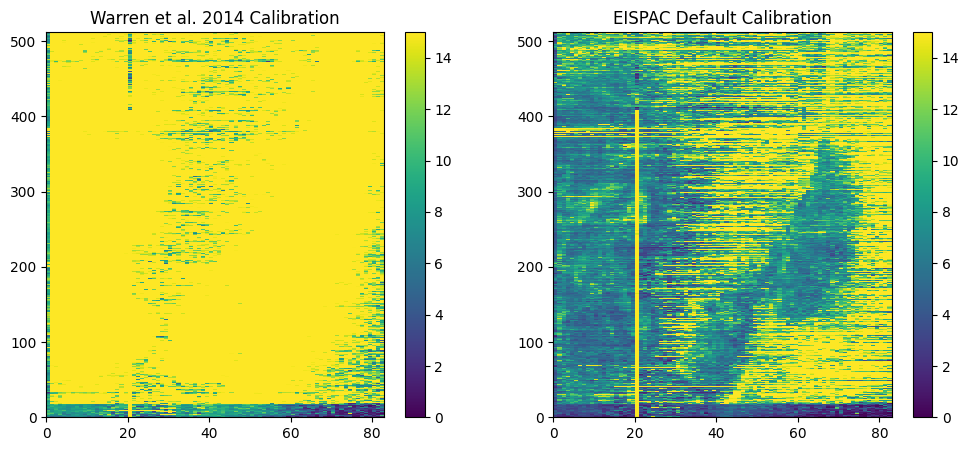

In [185]:
# fig = plt.figure(figsize=  (10,10))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=  (12,5))
im1 = ax1.pcolormesh(comp['chi2'],vmin=0,vmax=15)
im2 = ax2.pcolormesh(comp_old['chi2'], vmin=0,vmax=15)

# Add colorbars
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)

ax1.set_title('Warren et al. 2014 Calibration')
ax2.set_title('EISPAC Default Calibration')

In [135]:
comp_old = np.load('/Users/andysh.to/Script/Python_Script/spice/images/composition/eis_20230327_092942_composition_sis.npz')

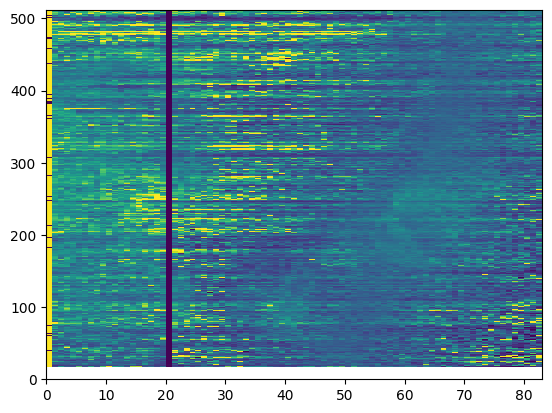

In [137]:
plt.pcolormesh(comp_old['composition'],vmin=0,vmax=4)

## 2023 EIS Calibration 

In [52]:
import datetime
import re
def anytim2tai(time_str):
    """
    Converts a given time string into TAI (Temps Atomique International) format.

    Parameters
    ----------
    time_str : str
        The time string to be converted. It should be in the format 'YYYY-MM-DD HH:MM:SS'.

    Returns
    -------
    float
        The corresponding TAI time value as seconds since 1 January 1958.

    Notes
    -----
    This function assumes that the input time string is in UTC (Coordinated Universal Time).
    The conversion from UTC to TAI is based on the assumption that TAI is always ahead of UTC
    by a fixed offset of 37 seconds.

    """
    # Check if the time string contains a 'T' separator
    if 'T' in time_str:
        # Split the date and time components using the 'T' separator
        date_str, time_str = time_str.split('T')
        # Combine the date and time components with a space separator
        time_str = f"{date_str} {time_str}"
    else:
        # Remove any non-alphanumeric characters from the time string
        time_str = re.sub(r'[^\w\s]', '', time_str)

    # Parse the input time string into a datetime object
    dt = datetime.datetime.strptime(time_str.replace('.000',''), '%Y-%m-%d %H:%M:%S')

    # Calculate the number of seconds since the Unix epoch (1 January 1970)
    seconds_since_epoch = (dt - datetime.datetime(1970, 1, 1)).total_seconds()

    # Calculate the number of seconds between the TAI epoch (1 January 1958) and the Unix epoch
    tai_offset = (datetime.datetime(1970, 1, 1) - datetime.datetime(1958, 1, 1)).total_seconds()

    # Add the offset to the seconds since the Unix epoch to get the TAI time value
    tai_time = seconds_since_epoch + tai_offset

    # Add the fixed offset between UTC and TAI (37 seconds)
    tai_time += 37

    return tai_time

### Tested - same TAI as IDL

In [26]:
time_str = '2020-03-27T06:12:18'
tai_time = anytim2tai(time_str)
print(tai_time)

1963980775.0


In [27]:
time_str = '2023-12-28T23:59:59'
tai_time = anytim2tai(time_str)
print(tai_time)


2082499236.0


In [29]:
from scipy.io import readsav

In [31]:
fit_ea = readsav('/Users/andysh.to/Script/Python_Script/demcmc_FIP/eis_calibration/fit_eis_ea_2023-05-04.sav')['fit_ea']

In [37]:
fit_dates = fit_ea.date_obs[0]
fit_easw = fit_ea.sw_ea[0]
fit_ealw = fit_ea.lw_ea[0]
sw_wave = fit_ea.sw_wave[0]
lw_wave = fit_ea.lw_wave[0]

In [74]:
len(fit_easw)

49

In [96]:
fit_ea.sw_ea[0].shape

(49, 31)

### Tested, same as IDL

In [141]:
from scipy.interpolate import InterpolatedUnivariateSpline

def interpol_eis_ea(date, wavelength, short=False, long=False, radcal=False, ea_file=None, quiet=False):
    # Validate input values
    if np.size(date) != 1:
        raise ValueError('ERROR: please input a single date')

    in_tai = anytim2tai(date)

    if in_tai < anytim2tai('2006-10-20T10:20:00.000'):
        print('WARNING: Selected date is before the start of normal EIS science operations. Output values may be inaccurate.')

    if not short and not long:
        n_input_wave = np.size(wavelength)
        loc_short = np.atleast_1d((wavelength >= 165) & (wavelength <= 213)).nonzero()[0]
        loc_long = np.atleast_1d((wavelength >= 245) & (wavelength <= 292)).nonzero()[0]
        if (len(loc_short) + len(loc_long) < n_input_wave) or (len(loc_short) > 0 and len(loc_long) > 0):
            raise ValueError('ERROR: Invalid wavelength(s). Please only select values in either the short (165 - 213) or long (245 - 292) wavelength bands.')
    if short:
        wavelength = 1
    elif long:
        wavelength = 1000

    fit_ea = readsav('/Users/andysh.to/Script/Python_Script/demcmc_FIP/eis_calibration/fit_eis_ea_2023-05-04.sav')['fit_ea']
    # Extract the necessary data from the loaded file
    fit_dates = fit_ea.date_obs[0].astype(str)
    fit_easw = fit_ea.sw_ea[0]
    fit_ealw = fit_ea.lw_ea[0]
    sw_wave = fit_ea.sw_wave[0]
    lw_wave = fit_ea.lw_wave[0]

    ref_tai = np.array([anytim2tai(date) for date in fit_dates])

    if in_tai < ref_tai[0]:
        if not quiet:
            print(f"WARNING: Selected date is before the first calibrated date on {fit_ea.date_obs[0]}. Returning first fit calibration")
        in_tai = ref_tai[0]

    if in_tai > ref_tai[-1]:
        if not quiet:
            print(f"WARNING: Selected date is after the last calibrated date on {fit_ea.date_obs[-1]}. Returning last fit calibration")
        in_tai = ref_tai[-1]

    # Select out the desired waveband
    if short or (np.size(wavelength) > 0 and np.max(wavelength) < 220):
        ref_ea = fit_easw
        ref_wave = sw_wave
    else:
        ref_ea = fit_ealw
        ref_wave = lw_wave

    # Interpolate the EA curve to the selected date and wavelength value
    # Interpolate the EA curve to the selected date and wavelength value
    n_ref_waves = len(ref_wave)
    new_ea = np.zeros(n_ref_waves)
    for w in range(n_ref_waves):
        ea_values = ref_ea[w,:]
        new_ea[w] = np.interp(in_tai, ref_tai, ea_values)
        
    if not short and not long:
        out_ea = interp1d(ref_wave, new_ea, kind='zero')(wavelength)
    else:
        wavelength = ref_wave
        out_ea = new_ea

    # Compute the radcal curve or value (if requested)
    if radcal:
        # Define unit conversion factors
        sr_factor = (725.0 / 1.496e8) ** 2
        ergs_to_photons = 6.626e-27 * 2.998e10 * 1.e8
        gain = 6.3
        phot_to_elec = 12398.5 / 3.65
        tau_sensitivity = 1894.0

        print('Returning radcal values for converting [DN/s] to [ergs/(sr cm^2 s)]')
        print('   Note: You may still need to adjust for exposure time and slitsize.')

        # Convert from [DN/s] to [photons/(arcsec^2 * cm^2 * s)]
        radcal = (wavelength * gain) / (out_ea * phot_to_elec)

        # Convert to units of [ergs/(sr cm^2 s)]
        radcal = radcal * ergs_to_photons / wavelength / sr_factor

        out_ea = radcal

    return out_ea


array(0.02690736)

In [137]:
# Convert each time string to TAI format
tai_times = [anytim2tai(time_str.decode().replace('.000','')) for time_str in fit_dates]


In [48]:
tai_times

[1554120037.0,
 1569931237.0,
 1585742437.0,
 1601553637.0,
 1617278437.0,
 1633089637.0,
 1648814437.0,
 1664625637.0,
 1680350437.0,
 1696161637.0,
 1711972837.0,
 1727784037.0,
 1743508837.0,
 1759320037.0,
 1775044837.0,
 1790856037.0,
 1806580837.0,
 1822392037.0,
 1838203237.0,
 1854014437.0,
 1869739237.0,
 1885550437.0,
 1901275237.0,
 1917086437.0,
 1932811237.0,
 1948622437.0,
 1964433637.0,
 1980244837.0,
 1995969637.0,
 2011780837.0,
 2027505637.0]

In [19]:
get_time_tai(date)

1419814799.0

In [14]:
date = '2007-12-28T23:59:59'

date_object = datetime.fromisoformat(date)
unix_timestamp = date_object.timestamp()
unix_timestamp

1198886399.0

In [15]:
date0 = '2006-10-20T10:20:00.000'
date_object = datetime.fromisoformat(date0)
unix_timestamp = date_object.timestamp()
unix_timestamp

1161336000.0

In [16]:
1161336000.0+1198886399.0

2360222399.0